## Sequential Backward Feature Selector
Sequential backward selection is a greedy search algorithm that tries to reduce the initial feature space to a reduced feature subspace.
The motivation for performing this feature reduction is to remove the less important features from the feature space. It will automatically selects a subsets of features that are a better predictors of the target variable. This will results in reducing the complexity and computational performance of the model and more importantly, improves the generalization performance of the model. This is specially helpful for the models that don't support regularization like K-Nearest Neighborhood algorithms.

### Implementation
We start with the full set of available features in the dataset and then sequentially remove the number of features until we reach to a desired number of features.
After reducing the number of features, we try every possible combination set of remaining features and then keep the combination that results in the highest score.

For example if the initial feature space has 5 features (0,1,2,3,4) and we want to reduce it 4 :

Initial feature space: 

(0,1,2,3,4)

Here is the possible combination of 4 features from our initial 5 feature space along with their accuracy:

| Combinations | Accuracy |
|--------------|----------|
| (0,1,2,3)    | 0.93     |
| (0,1,2,4)    | 0.92     |
| (0,1,3,4)    | 0.85     |
| (0,2,3,4)    | 0.95    |
| (1,2,3,4)    | 0.88     |


<br>

We fit the estimator using a training set that only has the selected feature in each combination and calculate the score accuracy. The combination with the highest score is selected as the best features for this reduced subspace. We use this and go to the next step to reduce the features again : 
So, from the previous step (0,2,3,4) had the highest score :

Initial feature set: 
(0,2,3,4) 


Here is the possible combination of 3 features from our initial 4 feature space along with their accuracy:

| Combinations | Accuracy |
|--------------|----------|
| (0,2,3)      | 0.95     |
| (0,2,4)      | 0.94     |
| (0,3,4)      | 0.97     |
| (2,3,4)      | 0.96     |


We can see that the accuracy (cross validation) has increased in our reduced subspace which could be due to the reduction in the over-fitting.

Let's see all of this in action by running the model on an actual dataset:


In [37]:
"""
Created on Sat May 9 11:35:12 2020
@author: Mahmood Khordoo
https://github.com/khordoo
"""
from itertools import combinations
from sklearn.model_selection import cross_val_score


class SequentialBackwardSelector:
    """
    Sequential backward selector for Scikit-learn estimators.
    """

    def __init__(self, estimator, reduced_feature_size=1, use_cross_val=True):
        self.estimator = estimator
        self.use_cross_val = use_cross_val
        self.reduced_feature_size = reduced_feature_size
        self.best_features_ = []

    def fit(self, X, y):
        """Finds a reduced set of features that results in the highest accuracy.
        Sequentially removes the available features, evaluates the model
        accuracy the all the possible combinations
        of the reduced feature subspace and keeps the best(highest accuracy)
        combination of features for each reduced feature size.

        Parameters
        ----------
        X : Numpy array
        y : Numpy array

        Returns
        -------
         None
        """

        feature_size = X.shape[1]
        keep_features = range(feature_size)

        while feature_size >= self.reduced_feature_size:
            best_feature_combination = None
            best_score = 0

            for feature_combination in combinations(keep_features, feature_size):
                score = self._score(X, y, feature_combination)
                if score > best_score:
                    best_score = score
                    best_feature_combination = feature_combination

            keep_features = best_feature_combination
            self._save_score(feature_size, best_score, best_feature_combination)
            feature_size -= 1

    def _score(self, X, y, selected_feature_indexes):
        if self.use_cross_val:
            score = cross_val_score(self.estimator, X[:, selected_feature_indexes], y).mean()
        else:
            self.estimator.fit(X[:, selected_feature_indexes], y)
            score = self.estimator.score(X[:, selected_feature_indexes], y)
        return score

    def _save_score(self, num_features, best_score, best_feature_combination):
        self.best_features_.append({
            'featureSize': num_features,
            'score': best_score,
            'features': best_feature_combination
        })


## Example

Here we are gonna try this on the wines dataset that initially has 13 features. We are going to fit an unregulated estimator , KNearestNeighbourhood from sklearn. Due to a high number of features and relatively small number of samples 178, there is a high change that the model would overfit. We will then try to sue Sequential Backward selection to find the best possible subset of features that result in higher accuracy.

### Data Preparation
We load the data from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/Wine);
it has 178 examples with 13 features.

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [39]:
df = pd.read_csv(
'https://archive.ics.uci.edu/ml/'
'machine-learning-databases/wine/wine.data',
header=None)
df.columns = ['Class label', 'Alcohol',
'Malic acid', 'Ash',
'Alcalinity of ash', 'Magnesium',
 'Total phenols', 'Flavanoids',
 'Nonflavanoid phenols',
 'Proanthocyanins',
 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines',
 'Proline']
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [43]:
X=df.iloc[:,1:]
y=df.iloc[:,0]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, stratify=y , random_state=2,shuffle=True)
sc=StandardScaler()
sc.fit(X_train)
X_train_s=sc.transform(X_train)
X_test_s=sc.transform(X_test)

## Backward Feature selection
Let's reduce the feature space from 13 to 1 and see how the accuracy changes in each reduced feature space.

In [44]:
%%capture
knn = KNeighborsClassifier(n_neighbors=10, p=2, n_jobs=4)
sbs = SequentialBackwardSelector(estimator=knn, reduced_feature_size=1, use_cross_val=True)
sbs.fit(X_train_s, y_train)

The best_features_ property of the SequnetialBackwardSelector object provides a list of best score and their corresponding feature indexes at each reduced feature subspace. 

In [42]:
sbs.best_features_

[{'featureSize': 13,
  'score': 0.959920634920635,
  'features': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)},
 {'featureSize': 12,
  'score': 0.9678571428571429,
  'features': (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12)},
 {'featureSize': 11,
  'score': 0.9837301587301588,
  'features': (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12)},
 {'featureSize': 10,
  'score': 0.9841269841269842,
  'features': (0, 1, 2, 3, 5, 6, 7, 9, 11, 12)},
 {'featureSize': 9,
  'score': 0.9841269841269842,
  'features': (0, 1, 2, 3, 5, 7, 9, 11, 12)},
 {'featureSize': 8,
  'score': 0.9761904761904762,
  'features': (0, 1, 2, 3, 5, 7, 9, 11)},
 {'featureSize': 7,
  'score': 0.9761904761904762,
  'features': (0, 1, 2, 3, 5, 9, 11)},
 {'featureSize': 6,
  'score': 0.9761904761904762,
  'features': (0, 1, 3, 5, 9, 11)},
 {'featureSize': 5, 'score': 0.9678571428571429, 'features': (0, 3, 5, 9, 11)},
 {'featureSize': 4, 'score': 0.959920634920635, 'features': (0, 3, 9, 11)},
 {'featureSize': 3, 'score': 0.9511904761904763, 'fea

### Plotting the results
Plotting the results shows that the accuracy has indeed increased by reducing the feature space. This shows that the model were previously suffering from the overfitting and by removing the redundant features we have increased the cross-validation accuracy and generalization performance of the model.
We can see that 6 features gives us the highest validation accuracy. Lets try to we what score we can get from over test set.

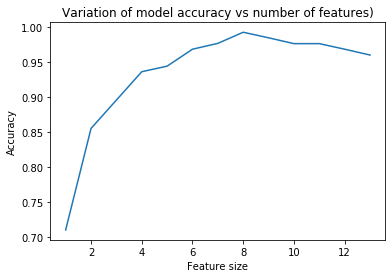

In [45]:
import matplotlib.pyplot as plt
#Just creating two arrays from a dictionariy items
num_features, scores = zip(*list(map(lambda x: [x['featureSize'], x['score']], sbs.best_features_)))
plt.title('Variation of model accuracy vs number of features)')
plt.xlabel('Feature size')
plt.ylabel('Accuracy')
plt.plot(num_features, scores)

As you can see we were able to increase the training accuracy of our model from 0.95 to 0.992 and test accuracy from  to 0.98 . We achieved the higher accuracy despite using  half of the initial available features. This shows that we have reduced the overfitting and have increased the generalization performance of our model.